In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image

### Split label file to train, val and test

In [ ]:
train_labels = labels.loc[0:5999,:]
train_labels.to_csv('/media/eslam/7AE0CA83E0CA455B/Users/Eslam100/Documents/kaggledataset/10k_part/train/labels.csv', sep=',')
val_labels = labels.loc[6000:7999,:]
val_labels.to_csv('/media/eslam/7AE0CA83E0CA455B/Users/Eslam100/Documents/kaggledataset/10k_part/val/labels.csv', sep=',')
test_labels = labels.loc[8000:9999,:]
test_labels.to_csv('/media/eslam/7AE0CA83E0CA455B/Users/Eslam100/Documents/kaggledataset/10k_part/test/labels.csv', sep=',')



### Customized dataloader for the dataset

In [2]:
class myDataset(Dataset):
    def __init__(self, csv_path, root_dir):
        self.root_dir = root_dir
        
        self.data_info = pd.read_csv(csv_path, header=None)
        #image path
        self.img_array = np.asarray(self.data_info.iloc[1:,1])
        #labels
        self.labels = np.asarray(self.data_info.iloc[1:,2], dtype=np.uint8)
        #length of data
        self.data_len = len(self.data_info.index)
        #transformations on the batch
        self.transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
    
    def __len__(self):
        return self.data_len
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.img_array[idx] + '.jpeg')
        image = Image.open(img_path,'r')
        img_as_tensor = self.transformations(image)
        
        return {'image':img_as_tensor,'label':self.labels[idx]}
        #return sample
    

In [4]:
csv_path = '/media/eslam/7AE0CA83E0CA455B/Users/Eslam100/Documents/kaggledataset/10k_part/train/labels.csv'
root_dir = '/media/eslam/7AE0CA83E0CA455B/Users/Eslam100/Documents/kaggledataset/10k_part/train/'
trainset = myDataset(csv_path, root_dir)

In [5]:
trainloader  = DataLoader(dataset=trainset,
                         batch_size=10,
                         shuffle=False,
                         num_workers=4,
                         pin_memory=True)
for i, batch in enumerate(trainloader):
    print batch['label']
    print batch['image']
    break

tensor([ 0,  0,  0,  0,  1,  2,  4,  4,  0,  1], dtype=torch.uint8)
tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.00

### Plot a batch to make sure it's loaded properly

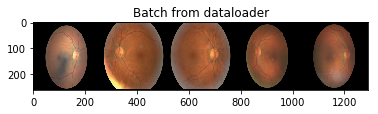

In [6]:
trainloader  = DataLoader(dataset=trainset,
                         batch_size=5,
                         shuffle=False,
                         num_workers=4,
                         pin_memory=True)

def plot_batch(sample_batch):
    images_batch = sample_batch['image']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.title('Batch from dataloader')
    
for i, sample_batch in enumerate(trainloader):
    if i ==3:
        plot_batch(sample_batch)
        plt.show()
        break

### Model architecture

In [ ]:
class ConvNet(nn.Module):
    super(ConvNet, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 32, 3)
    self.pool1 = nn.MaxPool2d(2, 2)
    
    self.conv3 = nn.Conv2d(32, 64, 3)
    self.conv4 = nn.Conv2d(64, 64, 3)
    self.pool2 = nn.MaxPool2d(2, 2)
    
    self.conv5 = nn.Conv2d(64, 128, 3)
    self.conv6 = nn.Conv2d(128, 128, 3)
    self.pool3 = nn.MaxPool2d(2, 2)
    
    self.conv7 = nn.Conv2d(128, 256, 3)
    self.con8 = nn.Conv2d(256, 256, 3)
    self.pool4 = nn.MaxPool2d(2, 2)
    
    self.fc1 = nn.Linear()
    
    
    